In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

pd.options.display.max_columns = 999

# Florida

## VEST Documentation

Election results from the Florida Department of State (https://dos.myflorida.com/elections/data-statistics/elections-data/precinct-level-election-results/)

Precinct results from several sources.  
- Alachua, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State.  
- Broward, Gadsden, Gilchrist, Manatee, Nassau, Santa Rosa, St. Johns, St. Lucie, and Union are from the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  
- Baker, Charlotte, Franklin, Glades, Holmes, Jackson, Jefferson, Levy, Liberty, Madison, Monroe, Okeechobee, Orange, Seminole, Suwannee, Taylor, Wakulla, Walton, and Washinton come from the U.S. Census Bureau's 2020 Redistricting Data Program.  
- Collier, Columbia, DeSoto, Duval, Flagler, Gulf, Highlands, Hillsborough, Lake, Lee, Leon, Marion, Martin, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Pinellas, Polk, Putnam, Sumter, and Volusia come from the counties.
- Hamilton was drawn based on a geocoded voter registration file.  
- Edits were made to Brevard, Charlotte, Escambia, Franklin, Indian River, Jefferson, Lafayette, Lake, and Lee, Miami-Dade, and St. Johns based on the voter registration file.  

Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREODEL - Roque "Rocky" De La Fuente (Reform Party)  
G20PRESLAR - Gloria La Riva (Party for Socialism and Liberation)  
G20PREGHAW - Howie Hawkin (Green Party)  
G20PRECBLA - Don Blankenship (Constitution Party)  
G20PREOWRI - Write-in Votes  

## Load VEST File

In [2]:
vest_fl_20 = gp.read_file("./raw-from-source/VEST/fl_2020/fl_2020.shp")

In [3]:
data_columns = [col for col in vest_fl_20.columns if "G20" in col]

## Load Election Results

Fields and codes data https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdfF

In [4]:
#This Data is from the FL department of state, and can only be downloaded county by county
all_files = os.listdir("./raw-from-source/Election_Results/2020-general-election-rev/")

In [5]:
#FRA replace ""AJ"" w/ "AJ"

In [6]:
#Check that all files have the same number of columns
for i in all_files:
    if i !=".DS_Store":
        ref = "./raw-from-source/Election_Results/2020-general-election-rev/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        print(file_prev.shape)
    
#All the files have 19 columns, so they should be good to combine

(803, 19)
(15647, 19)
(1189, 19)
(2632, 19)
(14289, 19)
(10445, 19)
(1756, 19)
(17138, 19)
(1242, 19)
(624, 19)
(774, 19)
(3108, 19)
(410, 19)
(86366, 19)
(2598, 19)
(4061, 19)
(11934, 19)
(2573, 19)
(13994, 19)
(51375, 19)
(28219, 19)
(1037, 19)
(796, 19)
(6699, 19)
(1805, 19)
(2965, 19)
(12062, 19)
(67003, 19)
(42208, 19)
(1154, 19)
(5629, 19)
(840, 19)
(7464, 19)
(25396, 19)
(3966, 19)
(884, 19)
(644, 19)
(888, 19)
(1908, 19)
(708, 19)
(4200, 19)
(3045, 19)
(1888, 19)
(2368, 19)
(2895, 19)
(1032, 19)
(1244, 19)
(9600, 19)
(11301, 19)
(1531, 19)
(538, 19)
(900, 19)
(6365, 19)
(1118, 19)
(908, 19)
(4810, 19)
(10570, 19)
(6289, 19)
(702, 19)
(3431, 19)
(8500, 19)
(1020, 19)
(1560, 19)
(9567, 19)
(1245, 19)
(1092, 19)
(740, 19)
(1268, 19)
(2099, 19)


In [7]:
li = []
for i in all_files:
    if i not in [".DS_Store","DAD_PctResults20201103recount.txt","BRO_PctResults20201103recount.txt"]:
        ref = "./raw-from-source/Election_Results/2020-general-election-rev/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        li.append(file_prev)
frame = pd.concat(li, axis=0, ignore_index=True)
print(frame.shape)

(553307, 19)


In [8]:
frame[frame[0]=="MRT"]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
458726,MRT,Martin,10866,11/03/2020,2020 General Election,1,Precinct 1,5960,0,0,0,President of the United States,,100000,Trump / Pence,REP,0,74773,3073
458727,MRT,Martin,10866,11/03/2020,2020 General Election,2,Precinct 2,6975,0,0,0,President of the United States,,100000,Trump / Pence,REP,0,74773,3579
458728,MRT,Martin,10866,11/03/2020,2020 General Election,3,Precinct 3,799,0,0,0,President of the United States,,100000,Trump / Pence,REP,0,74773,53
458729,MRT,Martin,10866,11/03/2020,2020 General Election,4,Precinct 4,4780,0,0,0,President of the United States,,100000,Trump / Pence,REP,0,74773,2207
458730,MRT,Martin,10866,11/03/2020,2020 General Election,5,Precinct 5,1621,0,0,0,President of the United States,,100000,Trump / Pence,REP,0,74773,870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460609,MRT,Martin,10866,11/03/2020,2020 General Election,24,Precinct 24,4228,0,0,0,Amendment No. 6: Ad Valorem Tax Discount for S...,Combat-Related Disabilities,900006,UnderVotes,,0,902,224
460610,MRT,Martin,10866,11/03/2020,2020 General Election,25,Precinct 25,5891,0,0,0,Amendment No. 6: Ad Valorem Tax Discount for S...,Combat-Related Disabilities,900006,UnderVotes,,0,902,329
460611,MRT,Martin,10866,11/03/2020,2020 General Election,26,Precinct 26,5665,0,0,0,Amendment No. 6: Ad Valorem Tax Discount for S...,Combat-Related Disabilities,900006,UnderVotes,,0,902,295
460612,MRT,Martin,10866,11/03/2020,2020 General Election,27,Precinct 27,5364,0,0,0,Amendment No. 6: Ad Valorem Tax Discount for S...,Combat-Related Disabilities,900006,UnderVotes,,0,902,301


In [9]:
frame =frame[frame[11]=='President of the United States']

In [10]:
filtered_frame = frame[~frame[14].isin(['OverVotes', 'UnderVotes'])]

In [11]:
filtered_frame[filtered_frame[0]=="DAD"][[5,6,7]]

,5,6,7
293943,10,PRECINCT 001.0,722
293944,20,PRECINCT 002.0,1671
293945,30,PRECINCT 003.0,2685
293946,40,PRECINCT 004.0,2614
293947,50,PRECINCT 005.0,3111
...,...,...,...
300866,9896,PRECINCT 994.0,889
300867,9897,PRECINCT 995.0,4728
300868,9898,PRECINCT 996.0,3087
300869,9899,PRECINCT 997.0,484


In [12]:
filtered_frame[6] = filtered_frame[6].astype(str)

<ipython-input-12-b6d26ad538c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame[6] = filtered_frame[6].astype(str)


In [13]:
filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row[6].split("PRECINCT ")[1])) if row[0]=="DAD" else row[5], axis=1)
#filtered_frame["mod_num"]=filtered_frame.apply(lambda x:x[6].split("PRECINCT ")[0] if x[0]=="DAD" else x)

<ipython-input-13-f79f07e4f382>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row[6].split("PRECINCT ")[1])) if row[0]=="DAD" else row[5], axis=1)


In [14]:
filtered_frame[filtered_frame[0]=="DAD"]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,mod_col
293943,DAD,Miami-Dade,10866,11/03/2020,2020 General Election,10,PRECINCT 001.0,722,0,0,0,President of the United States,,100000,Trump / Pence,REP,0,74773,395,1
293944,DAD,Miami-Dade,10866,11/03/2020,2020 General Election,20,PRECINCT 002.0,1671,0,0,0,President of the United States,,100000,Trump / Pence,REP,0,74773,713,2
293945,DAD,Miami-Dade,10866,11/03/2020,2020 General Election,30,PRECINCT 003.0,2685,0,0,0,President of the United States,,100000,Trump / Pence,REP,0,74773,1320,3
293946,DAD,Miami-Dade,10866,11/03/2020,2020 General Election,40,PRECINCT 004.0,2614,0,0,0,President of the United States,,100000,Trump / Pence,REP,0,74773,976,4
293947,DAD,Miami-Dade,10866,11/03/2020,2020 General Election,50,PRECINCT 005.0,3111,0,0,0,President of the United States,,100000,Trump / Pence,REP,0,74773,1314,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300866,DAD,Miami-Dade,10866,11/03/2020,2020 General Election,9896,PRECINCT 994.0,889,0,0,0,President of the United States,,100000,WriteinVotes,,0,900,0,994
300867,DAD,Miami-Dade,10866,11/03/2020,2020 General Election,9897,PRECINCT 995.0,4728,0,0,0,President of the United States,,100000,WriteinVotes,,0,900,8,995
300868,DAD,Miami-Dade,10866,11/03/2020,2020 General Election,9898,PRECINCT 996.0,3087,0,0,0,President of the United States,,100000,WriteinVotes,,0,900,8,996
300869,DAD,Miami-Dade,10866,11/03/2020,2020 General Election,9899,PRECINCT 997.0,484,0,0,0,President of the United States,,100000,WriteinVotes,,0,900,1,997


In [15]:
#Make the precinct column at least 4 digits
filtered_frame["mod_col"]=filtered_frame["mod_col"].astype(str)
filtered_frame["modified_pre"]=filtered_frame["mod_col"].str.zfill(4)

#Make a column with the 3 letter county code and the precincts
filtered_frame["Pct_std"]=filtered_frame[0]+filtered_frame["modified_pre"]

<ipython-input-15-dc049634ea23>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["mod_col"]=filtered_frame["mod_col"].astype(str)
<ipython-input-15-dc049634ea23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["modified_pre"]=filtered_frame["mod_col"].str.zfill(4)
<ipython-input-15-dc049634ea23>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [16]:
filtered_frame["Pct_std"]

0         OKE0001
1         OKE0002
2         OKE0003
3         OKE0004
4         OKE0005
           ...   
551403    GAD0021
551404    GAD0022
551405    GAD0023
551406    GAD0024
551407    GAD0025
Name: Pct_std, Length: 48776, dtype: object

In [17]:
#Pivot the data so that each row has all the results from that precinct
pivoted_2020 = pd.pivot_table(filtered_frame, values=[18], index=["Pct_std"],columns=[11,14],aggfunc=sum)

In [18]:
pivoted_2020.reset_index(inplace=True,drop=False)

In [19]:
pivoted_2020

Pct_std                             18                     \
11            President of the United States                      
14                            Biden / Harris Blankenship / Mohr   
0     ALA0001                            424                  0   
1     ALA0002                            752                  1   
2     ALA0003                           1431                  3   
3     ALA0004                            990                  1   
4     ALA0005                           1789                  0   
...       ...                            ...                ...   
6009  WAS0008                            318                  0   
6010  WAS0009                            139                  1   
6011  WAS0011                            126                  0   
6012  WAS0012                            210                  0   
6013  WAS0015                            180                  1   

                                                                   \
11                                                                  
14   De La Fuente / Richardson Hawkins / Walker Jorgensen / Cohen   
0                            2                1                 6   
1                            0                3                18   
2                            1                5                32   
3                            1                4                37   
4                            0               12                36   
...                        ...              ...               ...   
6009                         0                2                 2   
6010                         0                0                 8   
6011                         0                0                 1   
6012                         1                3                 5   
6013                         0                2                 5   

                                                   
11                                                 
14   La Riva / Freeman Trump / Pence WriteinVotes  
0                    1           725            1  
1                    0           969            8  
2                    0          2036           10  
3                    1          1749            7  
4                    0           624           18  
...                ...           ...          ...  
6009                 0           888            3  
6010                 1           655            0  
6011                 0           185            0  
6012                 2          1522            1  
6013                 1           795            0  

[6014 rows x 9 columns]

In [20]:
pivoted_2020.columns = ["pct_std","G20PREDBID","G20PRECBLA","G20PREODEL","G20PREGHAW","G20PRELJOR","G20PRESLAR","G20PRERTRU","G20PREOWRI"]





In [21]:
def statewide_totals_check(partner_df,source_df,column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      Nothing, only prints out an analysis
    """
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [22]:
statewide_totals_check(vest_fl_20,pivoted_2020,data_columns)

***Statewide Totals Check***
G20PRERTRU has a difference of 15 votes
	VEST: 5668731 votes
	SOURCES: 5668716 votes
G20PREDBID has a difference of 9 votes
	VEST: 5297045 votes
	SOURCES: 5297036 votes
G20PRELJOR has a difference of 1 votes
	VEST: 70324 votes
	SOURCES: 70323 votes
G20PREODEL is equal 	VEST / RDH: 5966
G20PRESLAR is equal 	VEST / RDH: 5712
G20PREGHAW is equal 	VEST / RDH: 14721
G20PRECBLA is equal 	VEST / RDH: 3902
G20PREOWRI is equal 	VEST / RDH: 24468


In [23]:
vest_fl_20

,pct_std,county,precinct,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREODEL,G20PRESLAR,G20PREGHAW,G20PRECBLA,G20PREOWRI,geometry
0,ALA0001,ALA,01,725,424,6,2,1,1,0,1,"POLYGON Z ((-82.24245 29.85246 0.00000, -82.24..."
1,ALA0002,ALA,02,969,752,18,0,0,3,1,8,"POLYGON Z ((-82.41775 29.92248 0.00000, -82.41..."
2,ALA0003,ALA,03,2036,1431,32,1,0,5,3,10,"POLYGON Z ((-82.53335 29.84801 0.00000, -82.52..."
3,ALA0004,ALA,04,1749,990,37,1,1,4,1,7,"POLYGON Z ((-82.55700 29.65461 0.00000, -82.55..."
4,ALA0005,ALA,05,624,1789,36,0,0,12,0,18,"POLYGON Z ((-82.34441 29.66672 0.00000, -82.34..."
...,...,...,...,...,...,...,...,...,...,...,...,...
6005,OSC0203,OSC,203,391,730,6,0,2,0,0,0,"MULTIPOLYGON Z (((-81.38822 28.32017 0.00000, ..."
6006,OSC0138,OSC,138,2,10,0,0,0,0,0,0,"POLYGON Z ((-81.44815 28.24601 0.00000, -81.45..."
6007,OSC0353,OSC,353,15,27,0,0,0,0,0,0,"POLYGON Z ((-81.44066 28.24602 0.00000, -81.44..."
6008,OSC0139,OSC,139,0,0,0,0,0,0,0,0,"POLYGON Z ((-81.45743 28.32764 0.00000, -81.45..."


In [24]:
pivoted_2020["county"] = pivoted_2020["pct_std"].str[0:3]

In [25]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [26]:
county_totals_check(vest_fl_20,pivoted_2020,data_columns,"county",full_print=False)

***Countywide Totals Check***

G20PRERTRU contains differences in these counties:
	MON has a difference of 10 votes
		VEST: 25693 votes
		SOURCES: 25683 votes
	SEM has a difference of 5 votes
		VEST: 125241 votes
		SOURCES: 125236 votes
G20PREDBID contains differences in these counties:
	MON has a difference of 5 votes
		VEST: 21881 votes
		SOURCES: 21876 votes
	SEM has a difference of 4 votes
		VEST: 132528 votes
		SOURCES: 132524 votes
G20PRELJOR contains differences in these counties:
	MON has a difference of 1 votes
		VEST: 348 votes
		SOURCES: 347 votes
G20PREODEL is equal across all counties
G20PRESLAR is equal across all counties
G20PREGHAW is equal across all counties
G20PRECBLA is equal across all counties
G20PREOWRI is equal across all counties


In [27]:
#vest_fl_20.groupby(["county"]).sum().to_csv("./vest_county_totals.csv")

### Precinct-by-Precinct Check

In [28]:
vest_fl_20["pct_std"].value_counts(dropna=False)

LEO5211    1
PIN0158    1
DAD0843    1
HIL0654    1
PAS0105    1
          ..
BRE0406    1
PIN0338    1
PIN0149    1
ESC0083    1
VOL0220    1
Name: pct_std, Length: 6010, dtype: int64

In [29]:
pivoted_2020["pct_std"].value_counts(dropna=False)

DAD0149    1
DAD0231    1
MON0010    1
PAL4132    1
MRN4720    1
          ..
BRE0406    1
DAD0067    1
PIN0149    1
ESC0083    1
VOL0220    1
Name: pct_std, Length: 6014, dtype: int64

In [30]:
for i in data_columns:
    pivoted_2020.loc[pivoted_2020["pct_std"]=="CHA54.0",i]+=int(pivoted_2020.loc[pivoted_2020["pct_std"]=="CHA54.1",i])

In [31]:
pivoted_2020.loc[pivoted_2020["pct_std"]=="CHA54.0"]

,pct_std,G20PREDBID,G20PRECBLA,G20PREODEL,G20PREGHAW,G20PRELJOR,G20PRESLAR,G20PRERTRU,G20PREOWRI,county
938,CHA54.0,441,0,0,0,0,0,635,2,CHA


In [32]:
pivoted_2020 = pivoted_2020[pivoted_2020["pct_std"]!="CHA54.1"]

Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

G20PRERTRU .................................................................BROZ073 (V) ....0  (S)..150 (D): -150
G20PREDBID .................................................................BROZ073 (V) ....0  (S)..262 (D): -262
G20PRERTRU .................................................................CHA0054 (V) ..635  (S)....0 (D):  635
G20PREDBID .................................................................CHA0054 (V) ..441  (S)....0 (D):  441
G20PRERTRU .................................................................CLL0450 (V) ....0  (S)...49 (D):  -49
G20PREDBID .................................................................CLL0450 (V) ....0  (S)...58 (D):  -58
G20PREDBID .................................................................HIL0946 (V) .4616  (S).4609 (D):    7
G20PRERTRU .................................................................HIL0999 (V) ....0  (S)..398 (D): -398
G20PREDBID .................................................................HIL0999 (V) ....0  (S)..533 (D): -533
G20PRELJOR .................................................................HIL0999 (V) ....0  (S)...27 (D):  -27
G20PREOWRI .................................................................HIL0999 (V) ....0  (S)....6 (D):   -6
G20PREDBID .................................................................LEO1321 (V) .2535  (S).2529 (D):    6
G20PREDBID .................................................................LEO2305 (V) .2786  (S).2780 (D):    6
G20PRERTRU .................................................................LEO9000 (V) ....0  (S)...90 (D):  -90
G20PREDBID .................................................................LEO9000 (V) ....0  (S)..233 (D): -233
G20PRERTRU .................................................................PIN0512 (V) ....0  (S)..355 (D): -355
G20PREDBID .................................................................PIN0512 (V) ....0  (S)..486 (D): -486
G20PRELJOR .................................................................PIN0512 (V) ....0  (S)...14 (D):  -14
G20PREOWRI .................................................................PIN0512 (V) ....0  (S)....8 (D):   -8

In [33]:
to_allocate = ['FLA0999',
 'LAK0108',
 'OSC0999',
 'PAL8001',
 'PAL8002',
 'SEM0900',
 'SEM0901',
 'SEM0902',
 'SEM0903',
 'SEM0904',
 'SEM0905',
 'SEM0906',
 'SEM0907',
 'SEM0908',
 'SEM0909',
 'SEM0910',
'BRE0999','DAD0100','BROZ073','CHA0054','CLL0450','HIL0999','LEO9000','PIN0512']

In [34]:
allocating_votes = pivoted_2020[pivoted_2020["pct_std"].isin(to_allocate)]
receiving_votes = pivoted_2020[~pivoted_2020["pct_std"].isin(to_allocate)]

In [35]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

In [36]:
pivoted_2020 = allocate_absentee(receiving_votes,allocating_votes,data_columns,"county",allocating_to_all_empty_precs=False)

In [37]:
join_attempt_one = pd.merge(vest_fl_20,pivoted_2020,how="outer",on="pct_std",indicator=True)

In [38]:
join_attempt_one["_merge"].value_counts()

both          5918
left_only       92
right_only      72
Name: _merge, dtype: int64

In [39]:
election_vest_id_changes = pd.read_csv("./election_vest_id_changes.csv")

In [40]:
election_vest_id_changes_dict = dict(zip(election_vest_id_changes["election_ID"],election_vest_id_changes["vest_ID"]))

In [41]:
pivoted_2020["pct_std"] = pivoted_2020["pct_std"].map(election_vest_id_changes_dict).fillna(pivoted_2020["pct_std"])

In [42]:
join_attempt_two = pd.merge(vest_fl_20,pivoted_2020,how="outer",on="pct_std",indicator=True)
join_attempt_two["_merge"].value_counts()

both          5990
left_only       20
right_only       0
Name: _merge, dtype: int64

In [43]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    """Checks a merged dataframe with two election results at the precinct level

    Args:
      merged_df: DataFrame with one set of election results joined to another
      column_list: List of races that there are votes for
      vest_on_left: Boolean specifying whether VEST data is on the left side of merged_df
      name_col: String of the column name to refer to precincts when a difference occurs
      print_level: Integer that specifies how large the vote difference in a precinct must be to be printed

    Returns:
      Nothing, only prints out an analysis
    """
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [44]:
precinct_votes_check(join_attempt_two[join_attempt_two["_merge"]=="both"],data_columns,True,"pct_std",print_level=0)

G20PRERTRU .................................................................MON0005 (V) .1000  (S)..999 (D):    1
G20PREDBID .................................................................MON0005 (V) .1706  (S).1705 (D):    1
G20PRELJOR .................................................................MON0005 (V) ...35  (S)...34 (D):    1
G20PREDBID .................................................................MON0006 (V) ..927  (S)..926 (D):    1
G20PREDBID .................................................................MON0008 (V) ..931  (S)..930 (D):    1
G20PREDBID .................................................................MON0010 (V) ..959  (S)..958 (D):    1
G20PRERTRU .................................................................MON0011 (V) .1213  (S).1212 (D):    1
G20PREDBID .................................................................MON0011 (V) .1101  (S).1100 (D):    1
G20PRERTRU .................................................................MON0012 (V) 

# Shapefiles

2020 doc:
    
Precinct results from several sources.  

4. Collier, Columbia, DeSoto, Duval, Flagler, Gulf, Highlands, Hillsborough, Lake, Lee, Leon, Marion, Martin, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Pinellas, Polk, Putnam, Sumter, and Volusia come from the counties.
5. Hamilton was drawn based on a geocoded voter registration file.  

### 1. Department of State

Quote from the documentation:

> Alachua, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State.  

In [45]:
ALA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/ALA/ALA20121106v6_PctMap/ALA20121106v6_PctMap.shp")
BAY_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BAY/BAY20120501_PctMap/CensusPrecinct_region.shp")
BRA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BRA/BRA20140106_PctMapaca38d35-1a03-4780-80bd-aa38a9b297c1/BRA20121106v6_PctMap/BRA20121106v5_PctMap.shp")
BRE_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/BRE/BRE20200430_Pct1370d2e2-064d-47b4-b963-43ee7731daee/BRE_Pct.shp")
CAL_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CAL/CAL20121106v6_PctMap/CAL20121106v6_PctMap.shp")
CIT_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CIT/CIT20200228_PctMapFile/PRECINCT2020.shp")
CLA_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/CLA/CLA20160503_PctMapcc84b5a6-3ade-4dd9-acd8-4c8157bcd343/CLA20160503_PctMap.shp")
DIX_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/DIX/DIX20121106v6_PctMap/DIX20121106v6_PctMap.shp")
ESC_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/ESC/Precinct_Map_2018/PRECINCT_MAP_022018.shp")
HAR_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HAR/HAR20121106v6_PctMap/HAR20121106v6_PctMap.shp")
HEN_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HEN/HEN20121106v6_PctMaped1303a5-dc65-41db-ac5f-a2bc3e07721a/HEN20121106v5_PctMap.shp")
HER_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/HER/HER20121106v6_PctMap/HER20121106v6_PctMap.shp")
IND_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/IND/IND20150210_PctMap/IND20150210_PctMap_region.shp")
LAF_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/LAF/LAF20121106v6_PctMap/LAF20121106v6_PctMap.shp")
SAR_pct=gp.read_file("./raw-from-source/Records_Request/Precinct and Polling Place Files - 2012-present - last checked 7-23-2020/SAR/SAR20140109v6_PctMapf831e47b-44f3-4954-a8e8-052b3a084322/SarasotaCounty_Pcts_051613_region.shp")

In [46]:
IND_pct

,PRECINCT,geometry
0,1,"POLYGON ((-80.67336 27.82132, -80.67340 27.819..."
1,10,"POLYGON ((-80.44448 27.76826, -80.44468 27.768..."
2,11,"POLYGON ((-80.41590 27.76120, -80.41596 27.761..."
3,12,"POLYGON ((-80.44575 27.73388, -80.44575 27.733..."
4,13,"POLYGON ((-80.38063 27.67677, -80.38064 27.676..."
5,14,"MULTIPOLYGON (((-80.40372 27.77802, -80.40586 ..."
6,15,"POLYGON ((-80.39942 27.76942, -80.40039 27.769..."
7,16,"POLYGON ((-80.36150 27.67491, -80.36193 27.674..."
8,17,"POLYGON ((-80.34609 27.62024, -80.34728 27.619..."
9,18,"POLYGON ((-80.32135 27.55715, -80.32312 27.557..."


In [47]:
BRE_pct

,PctsAreas,EPct_Area,Precinct,Commission,Congress,CityNum,House,CPA,RecDist,School,CDD,Senate,Sebastian,Ward,EPCT,Shape_Leng,Shape_Area,geometry
0,426-02,Area 02,426.1,4,8,0,52,0,4,4,0,17,1,0,426,904.119980,5.040791e+04,"POLYGON ((761858.156 1392239.081, 761859.091 1..."
1,415-02,Area 02,415.1,4,8,13,52,0,4,3,0,17,0,13,415,32944.293627,3.677263e+07,"POLYGON ((787354.672 1403540.228, 787857.873 1..."
2,308,None,308.1,3,8,10,53,0,4,3,0,17,1,10,308,43146.118375,9.078383e+07,"POLYGON ((795125.690 1348245.386, 795921.820 1..."
3,309-01,Area 01,309.1,3,8,15,53,0,4,5,0,17,1,15,309,73546.029118,1.339996e+08,"POLYGON ((770405.494 1361525.781, 770405.551 1..."
4,311,None,311.1,3,8,0,53,0,4,3,0,17,1,0,311,70270.941638,2.063543e+08,"POLYGON ((800360.065 1348247.990, 803940.795 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,503-04,Area 04,503.1,5,8,15,52,0,4,4,0,17,1,15,503,4327.375680,1.136596e+06,"POLYGON ((747838.768 1361485.984, 746571.407 1..."
359,412-02,Area 02,412.1,4,8,0,51,4,3,4,0,17,0,0,412,1043.595099,6.147901e+04,"POLYGON ((751286.859 1438266.462, 751286.500 1..."
360,435-04,Area 04,435.1,4,8,0,51,3,3,4,0,14,0,0,435,6341.142523,1.730574e+06,"POLYGON ((738937.485 1439052.437, 739701.033 1..."
361,442,None,442.1,4,8,12,51,3,3,4,0,14,0,12,442,15164.314404,1.166501e+07,"POLYGON ((738927.555 1439059.390, 738874.897 1..."


In [48]:
CLA_pct=CLA_pct.dissolve(by="PRECINCT")
CLA_pct.reset_index(inplace=True)

BAY_pct=BAY_pct.dissolve(by="PCT")
BAY_pct.reset_index(inplace=True)

BRE_pct=BRE_pct.dissolve(by="Precinct")
BRE_pct.reset_index(inplace=True)

In [49]:
ALA_pct['new_county']='ALA'
BAY_pct['new_county']='BAY'
BRA_pct['new_county']='BRA'
BRE_pct['new_county']='BRE'
CAL_pct['new_county']='CAL'
CIT_pct['new_county']='CIT'
CLA_pct['new_county']='CLA'
DIX_pct['new_county']='DIX'
ESC_pct['new_county']='ESC'
HAR_pct['new_county']='HAR'
HEN_pct['new_county']='HEN'
HER_pct['new_county']='HER'
IND_pct['new_county']='IND'
LAF_pct['new_county']='LAF'
SAR_pct['new_county']='SAR'

ALA_pct=ALA_pct.to_crs(vest_fl_20.crs)
BAY_pct=BAY_pct.to_crs(vest_fl_20.crs)
BRA_pct=BRA_pct.to_crs(vest_fl_20.crs)
BRE_pct=BRE_pct.to_crs(vest_fl_20.crs)
CAL_pct=CAL_pct.to_crs(vest_fl_20.crs)
CIT_pct=CIT_pct.to_crs(vest_fl_20.crs)
CLA_pct=CLA_pct.to_crs(vest_fl_20.crs)
DIX_pct=DIX_pct.to_crs(vest_fl_20.crs)
ESC_pct=ESC_pct.to_crs(vest_fl_20.crs)
HAR_pct=HAR_pct.to_crs(vest_fl_20.crs)
HEN_pct=HEN_pct.to_crs(vest_fl_20.crs)
HER_pct=HER_pct.to_crs(vest_fl_20.crs)
IND_pct=IND_pct.to_crs(vest_fl_20.crs)
LAF_pct=LAF_pct.to_crs(vest_fl_20.crs)
SAR_pct=SAR_pct.to_crs(vest_fl_20.crs)


#### Create a list with these counties precincts

In [50]:
fl_2020_shapefiles = [ALA_pct,BAY_pct,BRA_pct,BRE_pct,CAL_pct,CIT_pct,CLA_pct,DIX_pct,ESC_pct,HAR_pct,
HEN_pct,HER_pct,IND_pct,LAF_pct,SAR_pct]

#### Clean up these precinct files

In [51]:
cleaned_fl_list = []
for i in fl_2020_shapefiles:
    i.rename(columns={"PRECINCT":"Precinct","PCT":"Precinct","DISTRICT":"Precinct",
        "PrecMay201":"Precinct","PCT2014":"Precinct",'PRECINCTID':"Precinct"},inplace=True)
    i=i[["Precinct","geometry","new_county"]]
    i.rename(columns={"new_county":"county"},inplace=True)
    cleaned_fl_list.append(i)
    

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [52]:
BRE_pct

,Precinct,geometry,PctsAreas,EPct_Area,Commission,Congress,CityNum,House,CPA,RecDist,School,CDD,Senate,Sebastian,Ward,EPCT,Shape_Leng,Shape_Area,new_county
0,0.1,"MULTIPOLYGON (((-80.85510 28.25853, -80.85512 ...",0,None,1,8,0,51,1,0,1,0,14,0,0,0,164657.690168,2.928648e+08,BRE
1,100.1,"MULTIPOLYGON (((-80.84700 28.56882, -80.84731 ...",100-02,Area 02,1,8,0,50,1,1,1,0,14,0,0,100,3607.893766,5.082328e+05,BRE
2,102.1,"POLYGON ((-80.75079 28.46045, -80.73507 28.404...",102,None,1,8,0,51,2,0,1,0,14,0,0,102,54200.309779,1.104131e+08,BRE
3,103.1,"MULTIPOLYGON (((-80.85715 28.58341, -80.85715 ...",103-01,Area 01,1,8,0,50,1,1,1,0,14,0,0,103,231525.263501,1.306339e+09,BRE
4,104.1,"POLYGON ((-80.88983 28.71531, -80.88703 28.708...",104,None,1,8,0,50,1,1,1,0,14,0,0,104,195349.628121,1.405491e+09,BRE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,528.1,"POLYGON ((-80.59488 28.09026, -80.60374 28.085...",528,None,5,8,7,52,0,4,3,0,17,1,7,528,29912.063655,4.701520e+07,BRE
168,529.1,"POLYGON ((-80.60728 28.11408, -80.60398 28.107...",529,None,5,8,7,52,0,4,3,0,17,1,7,529,33454.223824,6.569890e+07,BRE
169,530.1,"MULTIPOLYGON (((-80.67911 28.08882, -80.67895 ...",530-01,Area 01,5,8,0,52,0,4,5,0,17,1,0,530,3752.470245,5.870308e+05,BRE
170,531.1,"POLYGON ((-80.72009 28.06433, -80.71994 28.064...",531,None,5,8,7,53,0,4,5,0,17,1,7,531,79082.283907,1.749507e+08,BRE


In [53]:
for i in cleaned_fl_list:
    if (i["county"].unique()==["BRE"]):
        i.loc[:,"Precinct"] = (i.loc[:,"Precinct"].astype(float)-.1).astype(int)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [54]:
cleaned_fl_list

[   Precinct                                           geometry county
 0        01  POLYGON Z ((-82.24245 29.85246 0.00000, -82.24...    ALA
 1        02  POLYGON Z ((-82.41775 29.92248 0.00000, -82.41...    ALA
 2        03  POLYGON Z ((-82.53335 29.84801 0.00000, -82.52...    ALA
 3        04  POLYGON Z ((-82.55700 29.65461 0.00000, -82.55...    ALA
 4        05  POLYGON Z ((-82.34441 29.66672 0.00000, -82.34...    ALA
 ..      ...                                                ...    ...
 58       59  POLYGON Z ((-82.33391 29.65234 0.00000, -82.33...    ALA
 59       60  POLYGON Z ((-82.57574 29.84031 0.00000, -82.57...    ALA
 60       61  POLYGON Z ((-82.38132 29.68867 0.00000, -82.38...    ALA
 61       62  POLYGON Z ((-82.44464 29.68893 0.00000, -82.44...    ALA
 62       63  POLYGON Z ((-82.41025 29.80052 0.00000, -82.41...    ALA
 
 [63 rows x 3 columns],
     Precinct                                           geometry county
 0          1  MULTIPOLYGON (((-85.75195 30.35964,

In [55]:
dos_shapefiles = pd.concat(cleaned_fl_list)

In [56]:
dos_shapefiles[dos_shapefiles["county"]=="BAY"]

,Precinct,geometry,county
0,1,"MULTIPOLYGON (((-85.75195 30.35964, -85.75103 ...",BAY
1,2,"POLYGON ((-85.47282 30.31336, -85.47296 30.313...",BAY
2,3,"POLYGON ((-85.47311 30.21631, -85.47328 30.216...",BAY
3,4,"POLYGON ((-85.52001 30.31507, -85.51839 30.314...",BAY
4,5,"POLYGON ((-85.65705 30.32230, -85.65734 30.322...",BAY
5,6,"POLYGON ((-85.67648 30.25773, -85.67854 30.257...",BAY
6,7,"POLYGON ((-85.75143 30.21117, -85.75180 30.211...",BAY
7,8,"POLYGON ((-85.99489 30.21056, -85.99989 30.213...",BAY
8,9,"POLYGON ((-85.95837 30.19539, -85.96213 30.196...",BAY
9,10,"POLYGON ((-85.87927 30.15627, -85.88519 30.159...",BAY


### 2. Orlando Sentinel Precinct Map

> Broward, Gadsden, Gilchrist, Manatee, Nassau, Santa Rosa, St. Johns, St. Lucie, and Union are from the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).

Note: We are not able to pull down the shapefile data from this map, but we do have screenshots saved in the raw-from-source file, available on request.

### 3. Census Source

Quote from the documentation:

> Baker, Charlotte, Franklin, Glades, Holmes, Jackson, Jefferson, Levy, Liberty, Madison, Monroe, Okeechobee, Orange, Seminole, Suwannee, Taylor, Wakulla, Walton, and Washinton come from the U.S. Census Bureau's 2020 Redistricting Data Program.

In [57]:
#When downloading from the Census redistricing data program, these use a FIPS code to identify counties

fips_codes = ["12003","12015","12037","12043","12047","12059","12063","12065","12075","12077","12079","12087","12093",
        "12095","12117","12121","12123","12129","12131","12133"]

#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/shapefiles/census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    li.append(file_prev)
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)
#print(shapefiles_census.shape)

In [58]:
#Make a dictionary to convert from FIPS identifier to the 3 character county name
county_code = {'003':'BAK','015':"CHA", '037':"FRA", '043':"GLA", '047':"HAM", '059':"HOL", '063':"JAC", '065':"JEF", 
               '075':"LEV", '077':"LIB", '079':"MAD",'087':'MON','093':"OKE", '095':"ORA",
 '117':"SEM", '121':"SUW", '123':"TAY", '129':"WAK", '131':"WAL", '133':"WAS"}

#Create a column with this 3-character county name
shapefiles_census['county_name'] = shapefiles_census['COUNTYFP'].map(county_code)

In [59]:
#Create a unique identifier, looks like "VTDST" is the best column to use for this, see above

#Work on the "NAMELSAD" column to just store this as well
shapefiles_census["NAMELSAD"]= shapefiles_census["NAMELSAD"].str.split("-", n = 1, expand = True)

#Take off the leading zero
shapefiles_census["VTDST"] = shapefiles_census["VTDST"].str.lstrip('0')

#Make sure they are all at least four digits
shapefiles_census["VTDST"] = shapefiles_census["VTDST"].str.zfill(4)
shapefiles_census["NAMELSAD"] = shapefiles_census["NAMELSAD"].str.zfill(4)

#Create the unique identifier
shapefiles_census["Pct_std"]=shapefiles_census["county_name"]+shapefiles_census["VTDST"]
shapefiles_census["alt_Pct_std"]=shapefiles_census["county_name"]+shapefiles_census["NAMELSAD"]

#Confirm that the unique identifier really is unique
print(shapefiles_census["Pct_std"].value_counts())

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_census=shapefiles_census[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_census = shapefiles_census.to_crs(vest_fl_20.crs)

MAD0006    1
ORA0632    1
CHA0050    1
ORA0543    1
ORA101B    1
          ..
MON0029    1
CHA0034    1
ORA0546    1
ORA0215    1
SEM0068    1
Name: Pct_std, Length: 716, dtype: int64


In [60]:
shapefiles_census

,Pct_std,geometry
0,BAK001A,"POLYGON Z ((-82.39816 30.31293 0.00000, -82.39..."
1,BAK002A,"POLYGON Z ((-82.18663 30.14274 0.00000, -82.18..."
2,BAK003A,"POLYGON Z ((-82.15124 30.29989 0.00000, -82.15..."
3,BAK004A,"POLYGON Z ((-82.45953 30.58425 0.00000, -82.45..."
4,BAK004B,"POLYGON Z ((-82.45941 30.57615 0.00000, -82.45..."
...,...,...
711,WAS007A,"POLYGON Z ((-85.49459 30.59116 0.00000, -85.49..."
712,WAS009C,"POLYGON Z ((-85.57625 30.66522 0.00000, -85.57..."
713,WAS009D,"POLYGON Z ((-85.56866 30.59079 0.00000, -85.56..."
714,WAS004D,"POLYGON Z ((-85.59231 30.74742 0.00000, -85.58..."


### 4. Counties Themselves

> Collier, Columbia, DeSoto, Duval, Flagler, Gulf, Highlands, Hillsborough, Lake, Lee, Leon, Marion, Martin, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Pinellas, Polk, Putnam, Sumter, and Volusia come from the counties.

What I was able to find:

- DeSoto - (not found) 
- Gulf - (not found) 
- Collier - (not found)    
- Flagler - (downloaded) 
- Highlands - (not found)  
- Hillsborough - (downloaded)   
- Lake - (not found)  
- Lee - (downloaded) 
- Leon - (downloaded)  
- Miami-Dade  - (downloaded)   
- Okaloosa  - (downloaded)  
- Osceola  -  (couldn't find)  
- Palm Beach  -  (downloaded)  
- Pasco  -  (downloaded) 
- Sumter  - (couldn't find)  
- Volusia  -  (couldn't find)  
- Columbia -  (couldn't find)   
- Duval -  (couldn't find)  
- Marion - (only map found) - https://www.votemarion.gov/Portals/Marion/Documents/DPT-ElectionSvc/Maps/Marion%20County%20Voting%20Precincts.pdf?ver=KGrM-e8c0jXjF2aAU9RDJg%3d%3d
- Martin - (found KML) - https://www.google.com/maps/d/viewer?mid=1p5VDI998WIl1433PfpkNgyKzmzwSXgmb&ll=27.110288969661138%2C-80.4541965&z=10
- Pinellas (found)
- Polk - (only map found)
- Putnam - https://pc-open-data-site-pcgis.hub.arcgis.com/datasets/8e7aa38f8b29431c99e0e716831e0e3e_0/explore

#### Load all the files

In [61]:
#For Collier, I had to load the KML into Google Earth Pro and then export it to get the precinct labels to show up (see report)

flagler_pcts = gp.read_file("./raw-from-source/shapefiles/counties/Flagler/2018-02-05/VTDBLK_1_region.shp")
shapefiles_hillsborough = gp.read_file("./raw-from-source/shapefiles/counties/Hillsborough/2017ShapeFiles/PRECINCT12057_region.shp")
shapefiles_leon = gp.read_file("./raw-from-source/shapefiles/counties/Leon/Election_Precincts_-_Leon_County-shp/Election_Precincts_-_Leon_County.shp")
shapefiles_miami = gp.read_file("./raw-from-source/shapefiles/counties/Miami/Miami_Precinct-shp/Precinct.shp")
shapefiles_okaloosa = gp.read_file("./raw-from-source/shapefiles/counties/Okaloosa/Voting/precinct.shp")
shapefiles_palm = gp.read_file("./raw-from-source/shapefiles/counties/Palm/Palm Beach SOE Shapefiles 2021/Precincts 2021.shp")
shapefiles_pasco = gp.read_file("./raw-from-source/shapefiles/counties/Pasco/Pasco VotingPrecincts/VotingPrecincts_12112020.shp")

In [102]:
shapefiles_collier = gp.read_file("./raw-from-source/shapefiles/counties/Collier/Precinct Boundaries_collier.kml",driver='KML')

In [105]:
shapefiles_lee = gp.read_file("./raw-from-source/shapefiles/counties/Lee/Lee County Precincts.kml",driver='KML',split="<br>")

In [109]:
shapefiles_martin =gp.read_file("./raw-from-source/shapefiles/counties/Martin/Martin County Voting Precincts (Interactive Street Map) (1).kml",driver='KML')

In [110]:
shapefiles_martin

,Name,Description,geometry
0,Precinct 1 - Hoke Library,1 <br> <br> DISTRICT 1 <br> GIS_AREA 4774.8509...,"POLYGON Z ((-80.28221 27.26381 0.00000, -80.28..."
1,Precinct 2 - TC3 Church,2 <br> <br> DISTRICT 2 <br> GIS_AREA 3566.3139...,"POLYGON Z ((-80.23622 27.24500 0.00000, -80.23..."
2,Precinct 3 - Boys & Girls Club of Indiantown,3 <br> <br> DISTRICT 3 <br> GIS_AREA 1356.7772...,"POLYGON Z ((-80.48265 27.02506 0.00000, -80.48..."
3,Precinct 4 - Langford Park,4 <br> <br> DISTRICT 4 <br> GIS_AREA 2550.1910...,"POLYGON Z ((-80.23985 27.21235 0.00000, -80.23..."
4,Precinct 5 - Blake Library,5 <br> <br> DISTRICT 5 <br> GIS_AREA 2205.0635...,"POLYGON Z ((-80.21188 27.20638 0.00000, -80.21..."
5,Precinct 6 - Covenant Fellowship Church,6 <br> <br> DISTRICT 6 <br> GIS_AREA 2476.9101...,"POLYGON Z ((-80.24625 27.15681 0.00000, -80.24..."
6,Precinct 7 - Women's Club of Stuart,7 <br> <br> DISTRICT 7 <br> GIS_AREA 2992.9620...,"POLYGON Z ((-80.22645 27.21228 0.00000, -80.23..."
7,Precinct 8 - 10th Street Recreation Center,8 <br> <br> DISTRICT 8 <br> GIS_AREA 558.55432...,"POLYGON Z ((-80.23038 27.19381 0.00000, -80.23..."
8,Precinct 9 - Elliott Museum,9 <br> <br> DISTRICT 9 <br> GIS_AREA 22006.300...,"POLYGON Z ((-80.20611 27.26307 0.00000, -80.20..."
9,Precinct 10 - Sewall's Point Town Hall,10 <br> <br> DISTRICT 10 <br> GIS_AREA 3048.52...,"POLYGON Z ((-80.21632 27.21190 0.00000, -80.21..."


In [106]:
shapefiles_lee

,Name,Description,geometry
0,(1) Alva Community Center,description: Precinct: 1<br>Address: 21471 Nor...,GEOMETRYCOLLECTION Z (POINT Z (-81.60794 26.71...
1,(2) Bethlehem Lutheran Church,description: Precinct: 2<br>Address: 14531 Old...,GEOMETRYCOLLECTION Z (POINT Z (-81.72160 26.71...
2,(3) St. Raphael's Catholic Church,description: Precinct: 3<br>Address: 2514 Lee ...,GEOMETRYCOLLECTION Z (POINT Z (-81.66320 26.61...
3,(4) East County Regional Library,description: Precinct: 4<br>Address: 881 Gunne...,GEOMETRYCOLLECTION Z (POINT Z (-81.71648 26.62...
4,(5) Sonshine Christian Academy,description: Precinct: 5<br>Address: 12925 Pal...,GEOMETRYCOLLECTION Z (POINT Z (-81.74560 26.70...
...,...,...,...
249,96,description: PRECINCT 96<br>Precinct: <br>Addr...,"POLYGON Z ((-81.94943 26.57796 0.00000, -81.94..."
250,97,description: PRECINCT 97<br>Precinct: <br>Addr...,"POLYGON Z ((-81.93071 26.57408 0.00000, -81.93..."
251,98,description: PRECINCT 98<br>Precinct: <br>Addr...,"POLYGON Z ((-81.91242 26.60804 0.00000, -81.91..."
252,99,description: PRECINCT 99<br>Precinct: <br>Addr...,"POLYGON Z ((-81.95061 26.60376 0.00000, -81.95..."


In [104]:
shapefiles_collier

,Name,Description,geometry
0,Precinct 101,West Wind Estates Comm Bldg<br>301 Joseph Ln<b...,"POLYGON Z ((-81.37502 25.81279 0.00000, -81.37..."
1,Precinct 102,Everglades City Hall<br>102 Copeland Ave N<br>...,"POLYGON Z ((-81.34397 26.04118 0.00000, -81.34..."
2,Precinct 103,First Haitian Baptist Church<br>14600 Tamiami ...,"POLYGON Z ((-81.67476 26.04776 0.00000, -81.67..."
3,Precinct 135,Glades Community Center<br>186 Teryl Rd<br>Nap...,"POLYGON Z ((-81.73016 26.12573 0.00000, -81.73..."
4,Precinct 139,Riviera Golf Estates Clubhouse<br>425 Charlema...,"POLYGON Z ((-81.72988 26.10956 0.00000, -81.72..."
5,Precinct 141,Hitching Post Recreation Hall<br>100 Barefoot ...,"POLYGON Z ((-81.70062 26.06419 0.00000, -81.70..."
6,Precinct 142,Isles of Capri Community Center<br>338 Capri B...,"POLYGON Z ((-81.62158 25.98881 0.00000, -81.62..."
7,Precinct 144,Shepherd of the Glades Church<br>6020 Rattlesn...,"POLYGON Z ((-81.60143 26.13182 0.00000, -81.60..."
8,Precinct 155,South Regional Library<br>8065 Lely Cultural P...,"POLYGON Z ((-81.67068 26.08369 0.00000, -81.67..."
9,Precinct 156,Eagle Lakes Community Park<br>11565 Tamiami Tr...,"POLYGON Z ((-81.71069 26.07120 0.00000, -81.71..."


In [62]:
shapefiles_pinellas = gp.read_file("./raw-from-source/shapefiles/counties/Pinellas/Voting_Precincts/Voting_Precincts.shp")
shapefiles_putnam = gp.read_file("./raw-from-source/shapefiles/counties/Putnam/Voting_Precincts_OD/Voting_Precincts.shp")

In [63]:
shapefiles_pinellas["PRECINCTID"].value_counts()

539    1
701    1
158    1
120    1
317    1
      ..
156    1
245    1
315    1
627    1
519    1
Name: PRECINCTID, Length: 301, dtype: int64

In [64]:
vest_proj = vest_fl_20.crs

#### Putnam County

In [65]:
shapefiles_putnam["PRECINCTID"] = shapefiles_putnam["PRECINCTID"].str.zfill(4)
shapefiles_putnam["Pct_std"]="PUT"+shapefiles_putnam["PRECINCTID"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_putnam=shapefiles_putnam[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_putnam=shapefiles_putnam.to_crs(vest_proj)

#### Pinellas County

In [66]:
shapefiles_pinellas

,OBJECTID,PRECINCTID,NAME,COUNTY,LASTUPDATE,LASTEDITOR,GLOBALID,CREATED_US,CREATED_DA,LAST_EDITE,LAST_EDI_1,SHAPESTAre,SHAPESTLen,geometry
0,300,101,None,None,None,None,{67436B0A-90BC-4532-8155-A1F098657201},None,None,None,None,3.197062e+07,26595.113952,"POLYGON ((-82.66285 27.71197, -82.66419 27.711..."
1,301,102,None,None,None,None,{0C965269-1D01-4826-B6E4-41F8C5B53101},None,None,None,None,1.409234e+07,15945.468593,"POLYGON ((-82.64634 27.70672, -82.64634 27.706..."
2,302,103,None,None,None,None,{F167C653-A07F-45C8-BD65-BBA9E9FD6A15},None,None,None,None,1.840186e+07,18715.225688,"POLYGON ((-82.64098 27.69946, -82.64621 27.698..."
3,303,104,None,None,None,None,{EB093059-5889-431C-BB27-2EE221C878B1},None,None,None,None,1.338193e+07,15239.032117,"POLYGON ((-82.63817 27.71492, -82.63820 27.714..."
4,304,105,None,None,None,None,{B172F78E-FA34-41D4-9546-4876BF646000},None,None,None,None,3.008652e+07,29650.625949,"POLYGON ((-82.64641 27.71943, -82.64742 27.719..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,596,705,None,None,None,None,{852AC476-A09A-4B18-9787-8E1BB1B4C9DA},None,None,None,None,3.362554e+07,26590.318873,"POLYGON ((-82.75667 28.13764, -82.75675 28.137..."
297,597,706,None,None,None,None,{56C03396-73BE-42D9-B1B2-E17BA355BF17},None,None,None,None,4.210834e+07,41144.066351,"POLYGON ((-82.75660 28.14563, -82.75661 28.145..."
298,598,710,None,None,None,None,{251200B8-ABA5-4E02-A1FE-7B13CFF230BF},None,None,None,None,1.153680e+07,22329.806707,"POLYGON ((-82.72724 28.15201, -82.72740 28.151..."
299,599,711,None,None,None,None,{422D418A-CCF6-41BF-BC7B-D123955AB886},None,None,None,None,2.718786e+08,81541.955981,"POLYGON ((-82.65034 28.14492, -82.65398 28.145..."


In [67]:
shapefiles_pinellas["PRECINCTID"] = shapefiles_pinellas["PRECINCTID"].str.zfill(4)
shapefiles_pinellas["Pct_std"]="PIN"+shapefiles_pinellas["PRECINCTID"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_pinellas=shapefiles_pinellas[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_pinellas=shapefiles_pinellas.to_crs(vest_proj)

#### Flagler County

In [68]:
#Take a look at the shapefile
#print(flagler_pcts.head())
#print(flagler_pcts.shape)

#"PRECINCT" is the right column to use, but it isn't unique (needs to be grouped by this)
#print(flagler_pcts["PRECINCT"].value_counts())

#Group by precinct # and reset index
shapefiles_flagler = flagler_pcts.dissolve(by="PRECINCT")
shapefiles_flagler = shapefiles_flagler.reset_index()

#Edit the precinct column to contain at least 4 character
shapefiles_flagler["PRECINCT"]= shapefiles_flagler["PRECINCT"].str.zfill(4)

#Create a unique identifer
shapefiles_flagler["Pct_std"]="FLA"+shapefiles_flagler["PRECINCT"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_flagler=shapefiles_flagler[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_flagler = shapefiles_flagler.to_crs(vest_proj)

#### Hillsborough County

In [69]:
#Take a look
#print(shapefiles_hillsborough.head())

#Use the "PRECINCT" column
#print(shapefiles_hillsborough["PRECINCT"].shape)

#Edit the precinct column to contain at least 4 character
shapefiles_hillsborough["PRECINCT"]= shapefiles_hillsborough["PRECINCT"].str.zfill(4)

#Create the unique identifer column
shapefiles_hillsborough["Pct_std"]="HIL"+shapefiles_hillsborough["PRECINCT"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_hillsborough=shapefiles_hillsborough[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_hillsborough = shapefiles_hillsborough.to_crs(vest_proj)

#### Leon County

In [70]:
#Take a look at the file
#print(shapefiles_leon.head())

#Edit the precinct column to contain at least 4 character
shapefiles_leon["PRECINCT"]= shapefiles_leon["PRECINCT"].str.zfill(4)

#Create the unique identifer column
shapefiles_leon["Pct_std"]="LEO"+shapefiles_leon["PRECINCT"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_leon=shapefiles_leon[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_leon = shapefiles_leon.to_crs(vest_proj)

#### Miami-Dade County

In [71]:
#Take a look, looks like "ID" is an okay column to use
#print(shapefiles_miami.head())

#Convert the ID column to contain at least 4 character
shapefiles_miami["ID"] = shapefiles_miami["ID"].apply(str)
shapefiles_miami["ID"] = shapefiles_miami["ID"].str.zfill(4)

#Create the unique identifer column
shapefiles_miami["Pct_std"]="DAD"+shapefiles_miami["ID"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_miami=shapefiles_miami[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_miami = shapefiles_miami.to_crs(vest_proj)

#### Okaloosa County

In [72]:
#Take a look
#print(shapefiles_okaloosa.head())

#Looks like "NO" is the right column, convert to string and edit to contain at least 4 characters
shapefiles_okaloosa["NO"] = shapefiles_okaloosa["NO"].apply(str)
shapefiles_okaloosa["NO"] = shapefiles_okaloosa["NO"].str.zfill(4)

#Create the unique identifer column
shapefiles_okaloosa["Pct_std"]="OKA"+shapefiles_okaloosa["NO"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_okaloosa=shapefiles_okaloosa[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_okaloosa = shapefiles_okaloosa.to_crs(vest_proj)

#### Palm Beach County

In [73]:
#Take a look, looks like "PRECINCT" is the column to use
#print(shapefiles_palm.head())

#Edit the precinct column to contain at least 4 character
shapefiles_palm["PRECINCT"]= shapefiles_palm["PRECINCT"].str.zfill(4)

#Create the unique identifer column
shapefiles_palm["Pct_std"]="PAL"+shapefiles_palm["PRECINCT"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_palm=shapefiles_palm[["Pct_std","geometry"]]

#Edit the CRS, so it matches that of the VEST file
shapefiles_palm = shapefiles_palm.to_crs(vest_proj)

#### Pasco County

In [74]:
#Take a look
#print(shapefiles_pasco.head())

#Seems like "Precinct" is the right column to use and that it is a unique value
#print(shapefiles_pasco["Precinct"].value_counts())

#Edit the precinct column to contain at least 4 character
shapefiles_pasco["Precinct"]= shapefiles_pasco["Precinct"].str.zfill(4)

#Create the unique identifer column
shapefiles_pasco["Pct_std"]="PAS"+shapefiles_pasco["Precinct"]

#Filter the columns to only include 'Pct_std' and geometry
shapefiles_pasco=shapefiles_pasco[["Pct_std","geometry"]]

#Take out that doesn't have any geometry (causing an issue)
shapefiles_pasco= shapefiles_pasco.drop([99])

#Edit the CRS, so it matches that of the VEST file
shapefiles_pasco = shapefiles_pasco.to_crs(vest_proj)

In [75]:
from_county_list = [shapefiles_flagler,shapefiles_hillsborough,
shapefiles_leon,
shapefiles_miami,
shapefiles_okaloosa,
shapefiles_palm,
shapefiles_pasco,shapefiles_pinellas,shapefiles_putnam]

mod_county_list = []
for val in from_county_list:
    print(val["Pct_std"])
    val = val[["Pct_std","geometry"]]
    
    mod_county_list.append(val)

0     FLA0001
1     FLA0010
2     FLA0011
3     FLA0013
4     FLA0014
5     FLA0015
6     FLA0016
7     FLA0017
8     FLA0018
9     FLA0019
10    FLA0020
11    FLA0021
12    FLA0023
13    FLA0024
14    FLA0027
15    FLA0029
16    FLA0003
17    FLA0031
18    FLA0033
19    FLA0035
20    FLA0037
21    FLA0005
22    FLA0007
23    FLA0008
24    FLA0009
25    FLA0998
Name: Pct_std, dtype: object
0      HIL0101
1      HIL0103
2      HIL0105
3      HIL0107
4      HIL0108
        ...   
385    HIL0980
386    HIL0981
387    HIL0982
388    HIL0983
389    HIL0999
Name: Pct_std, Length: 390, dtype: object
0      LEO3507
1      LEO3509
2      LEO3477
3      LEO3513
4      LEO5203
        ...   
159    LEO1205
160    LEO4152
161    LEO5105
162    LEO1301
163    LEO5101
Name: Pct_std, Length: 164, dtype: object
0      DAD0001
1      DAD0002
2      DAD0003
3      DAD0004
4      DAD0005
        ...   
778    DAD0994
779    DAD0995
780    DAD0996
781    DAD0997
782    DAD0999
Name: Pct_std, Length: 783, 

In [76]:
county_sourced = pd.concat(mod_county_list)

In [77]:
# #Take a look
# #print(shapefiles_lee.head())

# #From examining the map, only concerned with those that don't start with "()", as those designate a voting place, not an entire precinct
# shapefiles_lee["First_char"] = shapefiles_lee["Name"].astype(str).str[0]=="("
# shapefiles_lee = shapefiles_lee[shapefiles_lee["First_char"]==False]

# #Now can use the "Name" column to create the unique identifier
# shapefiles_lee["Name"]= shapefiles_lee["Name"].str.zfill(4)

# #Create the unique identifer column
# shapefiles_lee["Pct_std"]="LEE"+shapefiles_lee["Name"]

# #Filter the columns to only include 'Pct_std' and geometry
# shapefiles_lee=shapefiles_lee[["Pct_std","geometry"]]

# #Edit the CRS, so it matches that of the VEST file
# shapefiles_lee = shapefiles_lee.to_crs(vest_proj)

#### Collier County

In [78]:
# #The "Name" column seems like the best one to use, but needs to be cleaned
# #print(shapefiles_collier["Name"])
# shapefiles_collier["Name"] = shapefiles_collier["Name"].str.replace('Precinct ','')

# #Make sure the name column has at least four characters
# shapefiles_collier["Name"]= shapefiles_collier["Name"].str.zfill(4)

# #Create the unique identifier
# shapefiles_collier["Pct_std"]="CLL"+shapefiles_collier["Name"]

# #Filter the columns to only include 'Pct_std' and geometry
# shapefiles_collier=shapefiles_collier[["Pct_std","geometry"]]

# #Edit the CRS, so it matches that of the VEST file
# shapefiles_collier = shapefiles_collier.to_crs(vest_proj)

### 5. Geocoded Registration File

> Hamilton was drawn based on a geocoded voter registration file.  

Note: We are not able to create this file without more information

## Join Shapefiles to Election Results

In [79]:
dos_shapefiles["Precinct"] = dos_shapefiles["Precinct"].astype(str)
dos_shapefiles["Pct_std"] = dos_shapefiles["county"]+dos_shapefiles["Precinct"].str.zfill(4)
dos_shapefiles = dos_shapefiles[["Pct_std","geometry"]]

In [80]:
dos_shapefiles["Pct_std"].str[0:3].value_counts(dropna=False)

BRE    172
SAR     99
ESC     79
ALA     63
CLA     47
BAY     44
HER     39
IND     37
CIT     31
BRA     14
HAR     12
CAL     11
DIX     10
HEN     10
LAF      5
Name: Pct_std, dtype: int64

<AxesSubplot:>

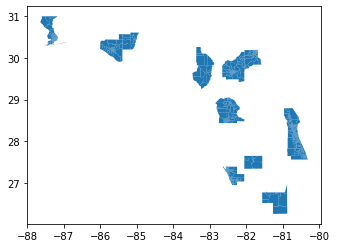

In [81]:
dos_shapefiles.plot()

In [82]:
shapefiles_census

,Pct_std,geometry
0,BAK001A,"POLYGON Z ((-82.39816 30.31293 0.00000, -82.39..."
1,BAK002A,"POLYGON Z ((-82.18663 30.14274 0.00000, -82.18..."
2,BAK003A,"POLYGON Z ((-82.15124 30.29989 0.00000, -82.15..."
3,BAK004A,"POLYGON Z ((-82.45953 30.58425 0.00000, -82.45..."
4,BAK004B,"POLYGON Z ((-82.45941 30.57615 0.00000, -82.45..."
...,...,...
711,WAS007A,"POLYGON Z ((-85.49459 30.59116 0.00000, -85.49..."
712,WAS009C,"POLYGON Z ((-85.57625 30.66522 0.00000, -85.57..."
713,WAS009D,"POLYGON Z ((-85.56866 30.59079 0.00000, -85.56..."
714,WAS004D,"POLYGON Z ((-85.59231 30.74742 0.00000, -85.58..."


In [83]:
county_sourced

,Pct_std,geometry
0,FLA0001,"POLYGON Z ((-81.26457 29.38609 0.00000, -81.26..."
1,FLA0010,"MULTIPOLYGON Z (((-81.23339 29.47878 0.00000, ..."
2,FLA0011,"POLYGON Z ((-81.25839 29.49610 0.00000, -81.25..."
3,FLA0013,"POLYGON Z ((-81.26272 29.52279 0.00000, -81.26..."
4,FLA0014,"POLYGON Z ((-81.22233 29.51307 0.00000, -81.22..."
...,...,...
30,PUT0037,"MULTIPOLYGON (((-81.65463 29.62590, -81.65462 ..."
31,PUT0032,"MULTIPOLYGON (((-81.65993 29.66733, -81.66140 ..."
32,PUT0030,"POLYGON ((-81.65322 29.62263, -81.65257 29.622..."
33,PUT0039,"MULTIPOLYGON (((-81.65830 29.65629, -81.65829 ..."


In [84]:
combined_shapefiles = pd.concat([dos_shapefiles,shapefiles_census,county_sourced])

In [85]:
combined_shapefiles["pct_std"] = combined_shapefiles["Pct_std"]

<AxesSubplot:>

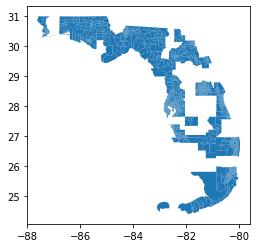

In [86]:
combined_shapefiles.plot()

In [87]:
pivoted_2020

,pct_std,G20PREDBID,G20PRECBLA,G20PREODEL,G20PREGHAW,G20PRELJOR,G20PRESLAR,G20PRERTRU,G20PREOWRI,county
0,ALA0001,424,0,2,1,6,1,725,1,ALA
1,ALA0002,752,1,0,3,18,0,969,8,ALA
2,ALA0003,1431,3,1,5,32,0,2036,10,ALA
3,ALA0004,990,1,1,4,37,1,1749,7,ALA
4,ALA0005,1789,0,0,12,36,0,624,18,ALA
...,...,...,...,...,...,...,...,...,...,...
6009,WAS0008,318,0,0,2,2,0,888,3,WAS
6010,WAS0009,139,1,0,0,8,1,655,0,WAS
6011,WAS0011,126,0,0,0,1,0,185,0,WAS
6012,WAS0012,210,0,1,3,5,2,1522,1,WAS


In [88]:
pivoted_2020['pct_std'].str[0:3].unique()

array(['ALA', 'BAK', 'BAY', 'BRA', 'BRE', 'BRO', 'CAL', 'CHA', 'CIT',
       'CLA', 'CLL', 'CLM', 'DAD', 'DES', 'DIX', 'DUV', 'ESC', 'FLA',
       'FRA', 'GAD', 'GIL', 'GLA', 'GUL', 'HAM', 'HAR', 'HEN', 'HER',
       'HIG', 'HIL', 'HOL', 'IND', 'JAC', 'JEF', 'LAF', 'LAK', 'LEE',
       'LEO', 'LEV', 'LIB', 'MAD', 'MAN', 'MON', 'MRN', 'MRT', 'NAS',
       'OKA', 'OKE', 'ORA', 'OSC', 'PAL', 'PAS', 'PIN', 'POL', 'PUT',
       'SAN', 'SAR', 'SEM', 'STJ', 'STL', 'SUM', 'SUW', 'TAY', 'UNI',
       'VOL', 'WAK', 'WAL', 'WAS'], dtype=object)

In [89]:
pivoted_2020[pivoted_2020['pct_std'].str[0:3]=="CLM"]

,pct_std,G20PREDBID,G20PRECBLA,G20PREODEL,G20PREGHAW,G20PRELJOR,G20PRESLAR,G20PRERTRU,G20PREOWRI,county
1095,CLM0010,796,1,1,2,1,3,196,1,CLM
1096,CLM0012,365,0,0,2,4,1,62,1,CLM
1097,CLM0013,11,0,0,0,1,0,55,0,CLM
1098,CLM0014,108,0,0,0,6,0,158,0,CLM
1099,CLM0015,100,2,0,0,3,0,423,0,CLM
1100,CLM0016,530,0,2,0,10,1,1105,3,CLM
1101,CLM0017,396,0,0,3,9,1,651,2,CLM
1102,CLM0021,297,0,1,1,6,0,1047,2,CLM
1103,CLM0022,337,0,1,2,14,3,1341,1,CLM
1104,CLM0023,1100,4,2,7,33,7,3521,10,CLM


In [90]:
no_results = ["HAM","CLM","LEE","LAK","OSC","HIG","SUM","VOL","CLL","DUV","BRO","GAD","GIL",
             "MAN","NAS","SAN","STJ","STL","UNI","DES","GUL","POL","MRN","MRT"]

elections_w_shapefiles = pivoted_2020[~pivoted_2020["county"].isin(no_results)]

In [91]:
final_source = pd.merge(elections_w_shapefiles,combined_shapefiles,on="pct_std",how="outer",indicator=True)

In [92]:
final_source["_merge"].value_counts()

both          3894
right_only     270
left_only      103
Name: _merge, dtype: int64

In [99]:
shp_id_changes = {"OKEP-01":"OKE0001",
"OKEP-02":"OKE0002",
"OKEP-03":"OKE0003",
"OKEP-04":"OKE0004",
"OKEP-05":"OKE0005",
"OKEP-06":"OKE0006",
"OKEP-07":"OKE0007",
"OKEP-08":"OKE0008",
"OKEP-09":"OKE0009",
"OKEP-10":"OKE0010",
"OKEP-11":"OKE0011"}
    


In [100]:
combined_shapefiles["pct_std"] = combined_shapefiles["pct_std"].map(shp_id_changes).fillna(combined_shapefiles["pct_std"])

In [101]:
final_source = pd.merge(elections_w_shapefiles,combined_shapefiles,on="pct_std",how="outer",indicator=True)
final_source["_merge"].value_counts()

both          3905
right_only     259
left_only       92
Name: _merge, dtype: int64

In [93]:
final_source[final_source["_merge"]=="left_only"].to_csv("./elections_only.csv")
final_source[final_source["_merge"]=="right_only"].to_csv("./shapes_only.csv")

In [94]:
combined_shapefiles["pct_std"].str[0:3].unique()

array(['ALA', 'BAY', 'BRA', 'BRE', 'CAL', 'CIT', 'CLA', 'DIX', 'ESC',
       'HAR', 'HEN', 'HER', 'IND', 'LAF', 'SAR', 'BAK', 'CHA', 'FRA',
       'GLA', 'HAM', 'HOL', 'JAC', 'JEF', 'LEV', 'LIB', 'MAD', 'MON',
       'OKE', 'ORA', 'SEM', 'SUW', 'TAY', 'WAK', 'WAL', 'WAS', 'FLA',
       'HIL', 'LEO', 'DAD', 'OKA', 'PAL', 'PAS', 'PIN', 'PUT'],
      dtype=object)

In [95]:
final_source[final_source["_merge"]=="left_only"]["pct_std"].str[0:3].unique()

array(['CHA', 'ESC', 'JAC', 'MON', 'OKE', 'ORA', 'PAS', 'SAR', 'WAS'],
      dtype=object)

In [96]:
for i in list(final_source[final_source["_merge"]=="left_only"]["pct_std"].str[0:3].unique()):
    if i not in list(combined_shapefiles["pct_std"].str[0:3].unique()):
        print(i)

In [97]:
dos_shapefiles[dos_shapefiles["Pct_std"].str[0:3]=="BAY"]

,Pct_std,geometry
0,BAY0001,"MULTIPOLYGON (((-85.75195 30.35964, -85.75103 ..."
1,BAY0002,"POLYGON ((-85.47282 30.31336, -85.47296 30.313..."
2,BAY0003,"POLYGON ((-85.47311 30.21631, -85.47328 30.216..."
3,BAY0004,"POLYGON ((-85.52001 30.31507, -85.51839 30.314..."
4,BAY0005,"POLYGON ((-85.65705 30.32230, -85.65734 30.322..."
5,BAY0006,"POLYGON ((-85.67648 30.25773, -85.67854 30.257..."
6,BAY0007,"POLYGON ((-85.75143 30.21117, -85.75180 30.211..."
7,BAY0008,"POLYGON ((-85.99489 30.21056, -85.99989 30.213..."
8,BAY0009,"POLYGON ((-85.95837 30.19539, -85.96213 30.196..."
9,BAY0010,"POLYGON ((-85.87927 30.15627, -85.88519 30.159..."


## Final Join to VEST